# i. Perkenalan

## Nama : Raymond Samuel
## Batch : RMT-030
## Objective : Membuat Model ANN untuk prediksi Emosi Wajah untuk mengetahui Ekpresi peserta kelas Hacktiv8 untuk meningkatkan efektifitas pembelajaran.

# ii. Import Libraries

In [1]:
# Import libraries
from PIL import Image

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization
from tensorflow.keras.regularizers import l2


from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# iii. Data Loading

Dataset URL : https://www.kaggle.com/datasets/muhammadafaq786/fer2013-images

In [2]:
# Install Kaggle library in Google Collaboratory

## Install Kaggle library
!pip install kaggle

## Make a directory named `.kaggle`
!mkdir ~/.kaggle

## Copy the kaggle.json into this new directory
!cp kaggle.json ~/.kaggle/

## Change permission for this directory :
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
%%time
# Download Dataset
!kaggle datasets download -d muhammadafaq786/fer2013-images

Dataset URL: https://www.kaggle.com/datasets/muhammadafaq786/fer2013-images
License(s): other
 85% 57.0M/66.9M [00:01<00:00, 53.4MB/s]
100% 66.9M/66.9M [00:01<00:00, 47.8MB/s]
CPU times: user 27.6 ms, sys: 2.82 ms, total: 30.4 ms
Wall time: 3.02 s


In [4]:
!unzip ./fer2013-images

Streaming output truncated to the last 5000 lines.
  inflating: archive(6)/validation/fear/8797.jpg  
  inflating: archive(6)/validation/fear/8818.jpg  
  inflating: archive(6)/validation/fear/886.jpg  
  inflating: archive(6)/validation/fear/9037.jpg  
  inflating: archive(6)/validation/fear/9040.jpg  
  inflating: archive(6)/validation/fear/9101.jpg  
  inflating: archive(6)/validation/fear/911.jpg  
  inflating: archive(6)/validation/fear/9179.jpg  
  inflating: archive(6)/validation/fear/9205.jpg  
  inflating: archive(6)/validation/fear/9232.jpg  
  inflating: archive(6)/validation/fear/9251.jpg  
  inflating: archive(6)/validation/fear/9261.jpg  
  inflating: archive(6)/validation/fear/9281.jpg  
  inflating: archive(6)/validation/fear/9302.jpg  
  inflating: archive(6)/validation/fear/9333.jpg  
  inflating: archive(6)/validation/fear/9369.jpg  
  inflating: archive(6)/validation/fear/9370.jpg  
  inflating: archive(6)/validation/fear/9474.jpg  
  inflating: archive(6)/validatio

In [5]:
# Define path

main_path = '/content/archive(6)'
train_path = os.path.join(main_path, 'train')
val_path = os.path.join(main_path, 'validation')
test_path = os.path.join(main_path, 'test')

In [6]:
# Check how many data in `train_path`, `val_path` and `test_path`

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Val Path')
check_path(val_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - fear : 4103
Total Data - surprise : 3205
Total Data - happy : 7164
Total Data - angry : 3993
Total Data - disgust : 436
Total Data - neutral : 4982
Total Data - sad : 4938

Val Path
Total Data - fear : 1018
Total Data - surprise : 797
Total Data - happy : 1825
Total Data - angry : 960
Total Data - disgust : 111
Total Data - neutral : 1216
Total Data - sad : 1139

Test Path
Total Data - fear : 528
Total Data - surprise : 626
Total Data - happy : 879
Total Data - angry : 491
Total Data - disgust : 55
Total Data - neutral : 594
Total Data - sad : 416



# iv. Exploratory Data Analysis (EDA)

In [7]:
# Function to visualize the first 5 images from each class
# from PIL import ImageFile

def plot_images(path):
  # ImageFile.LOAD_TRUNCATED_IMAGES = True
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        # image = plt.imread(os.path.join(folder_path, images[index]))
        img = Image.open(os.path.join(folder_path, images[index]))
        image = img.convert('RGB')
        plt.imshow(image)
        plt.axis("off")
    plt.show()

## Plot Image on Each Set

Class :  fear


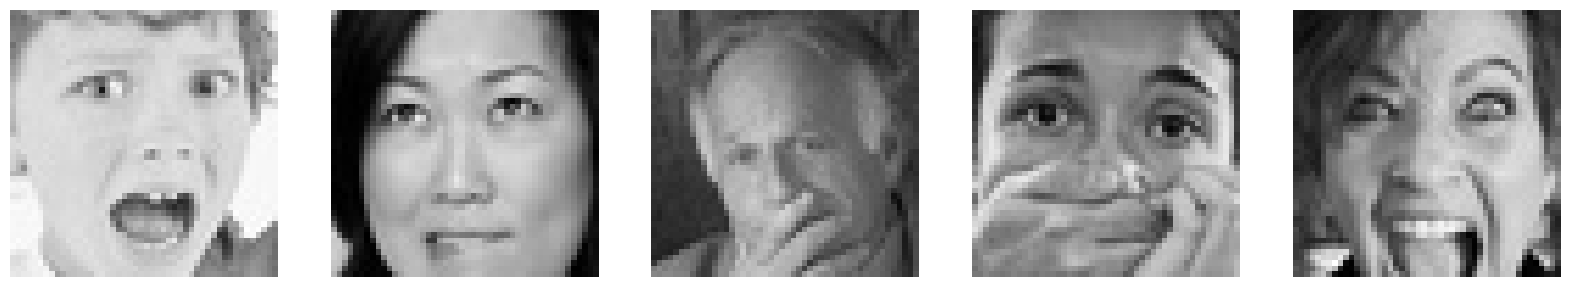

Class :  surprise


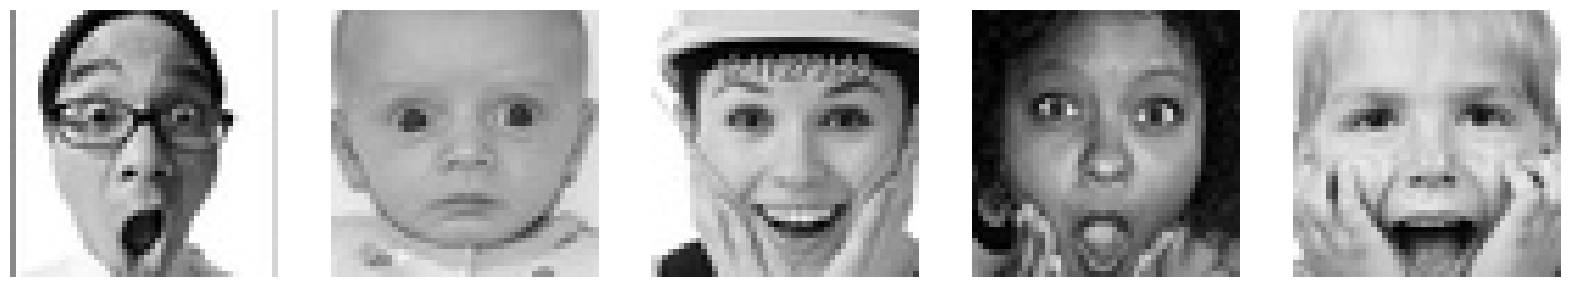

Class :  happy


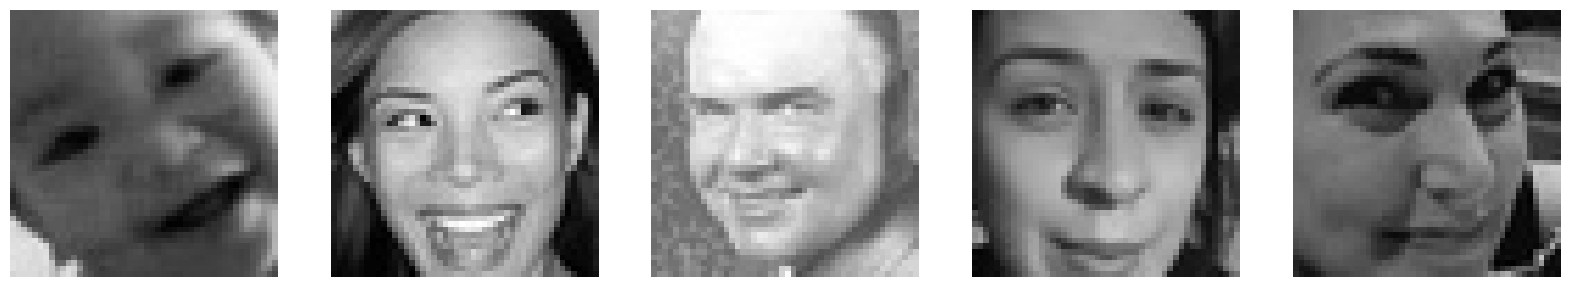

Class :  angry


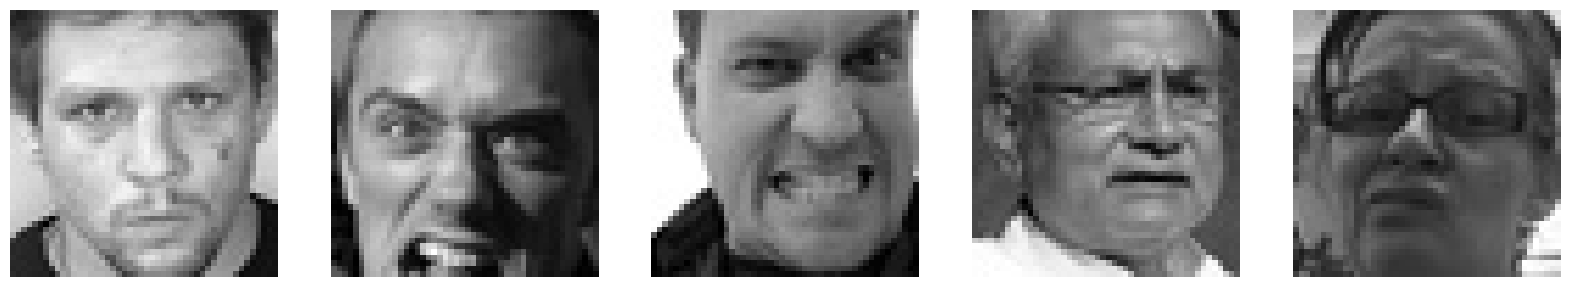

Class :  disgust


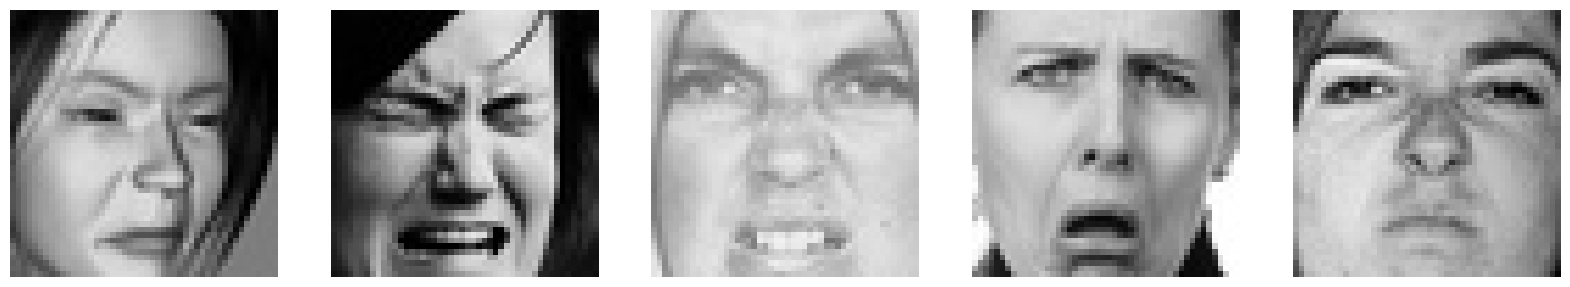

Class :  neutral


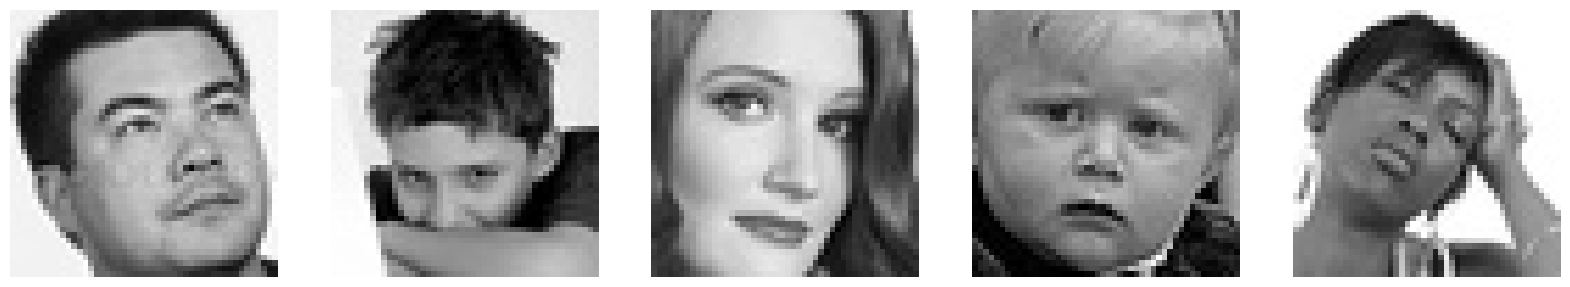

Class :  sad


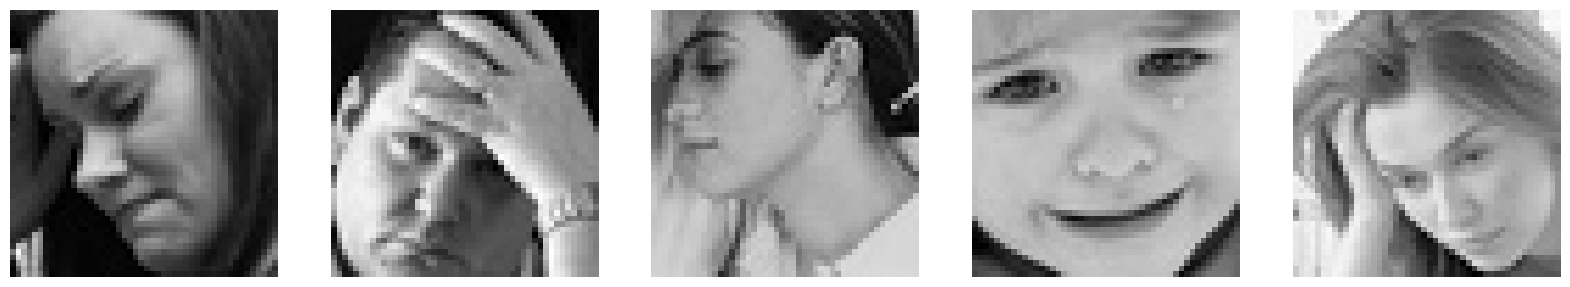

In [8]:
# Visualization of train_path

plot_images(train_path)

Class :  fear


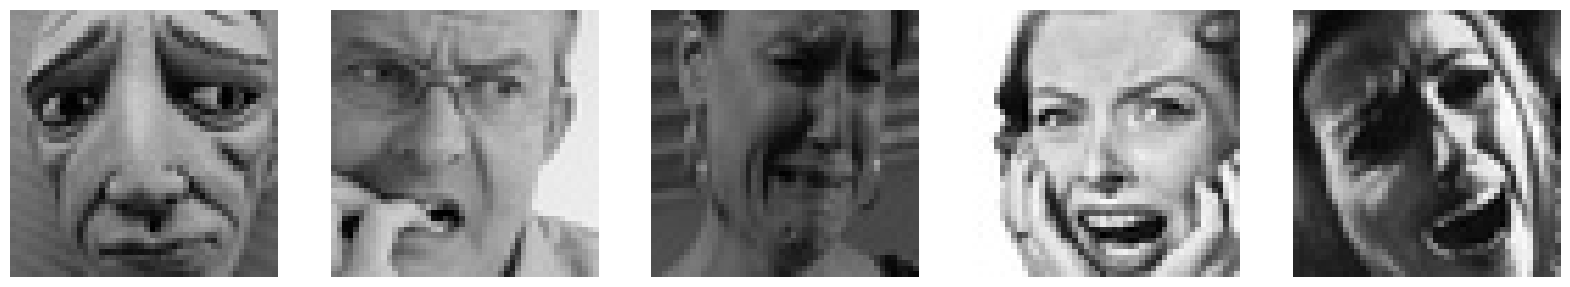

Class :  surprise


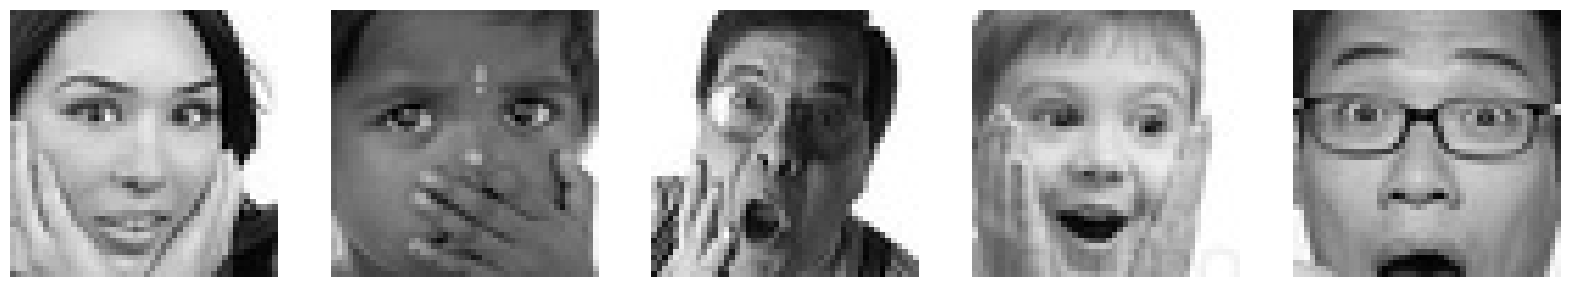

Class :  happy


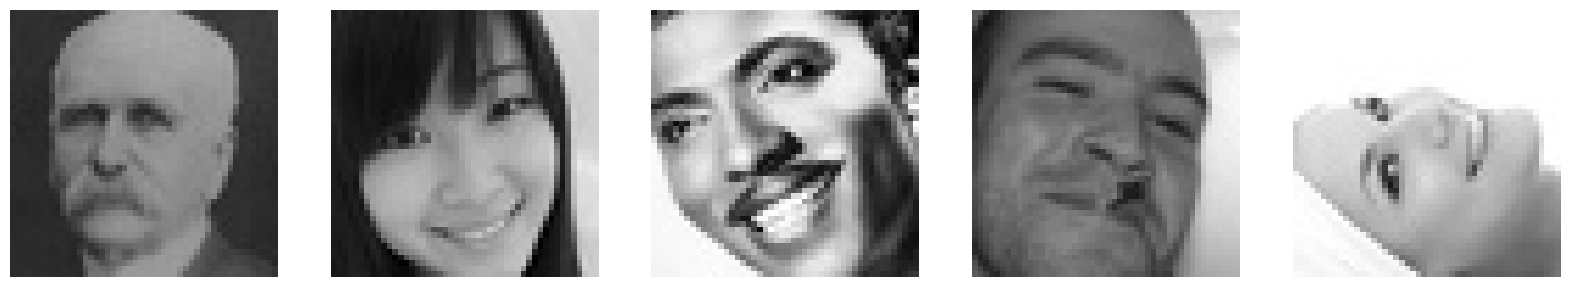

Class :  angry


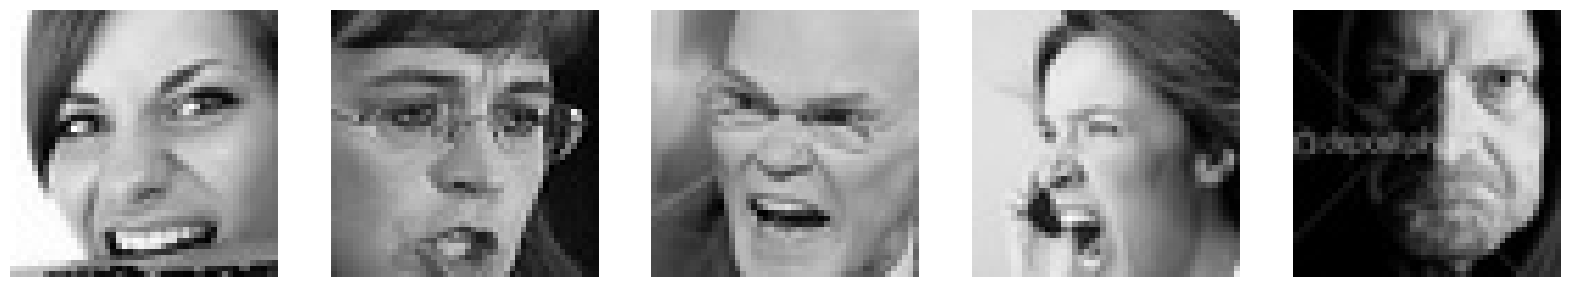

Class :  disgust


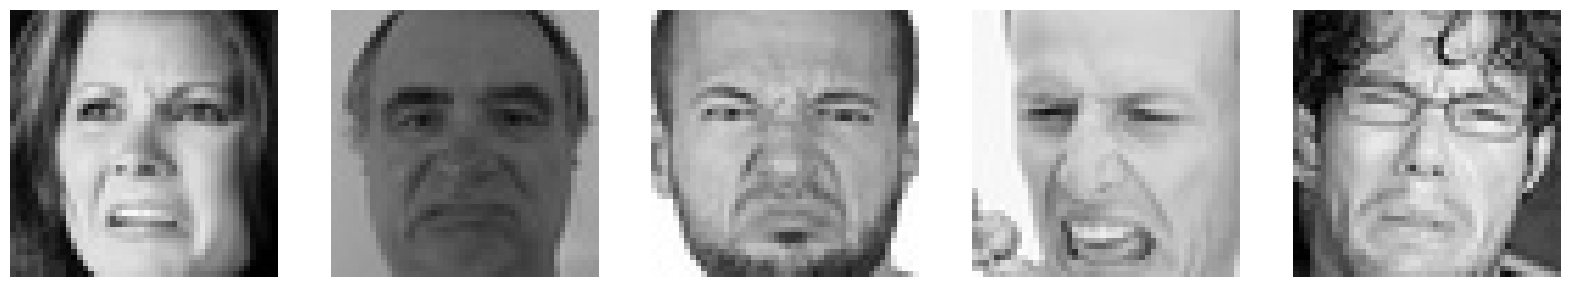

Class :  neutral


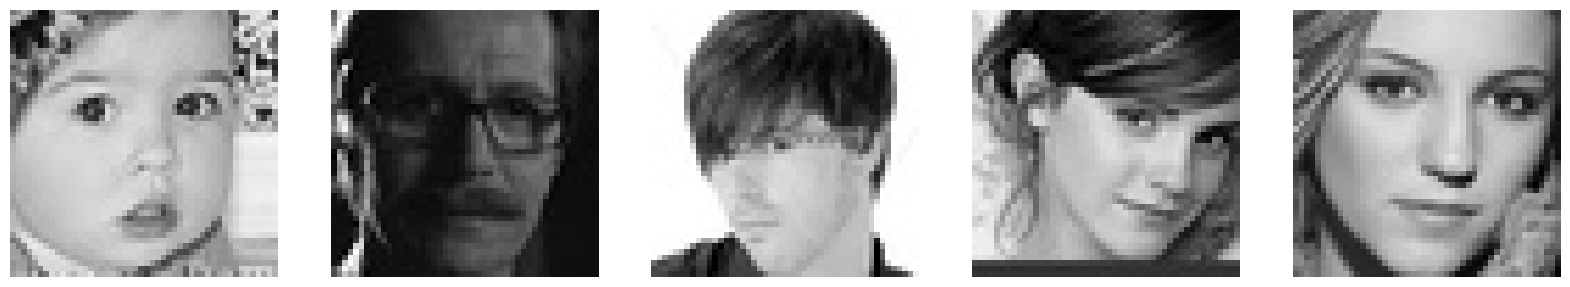

Class :  sad


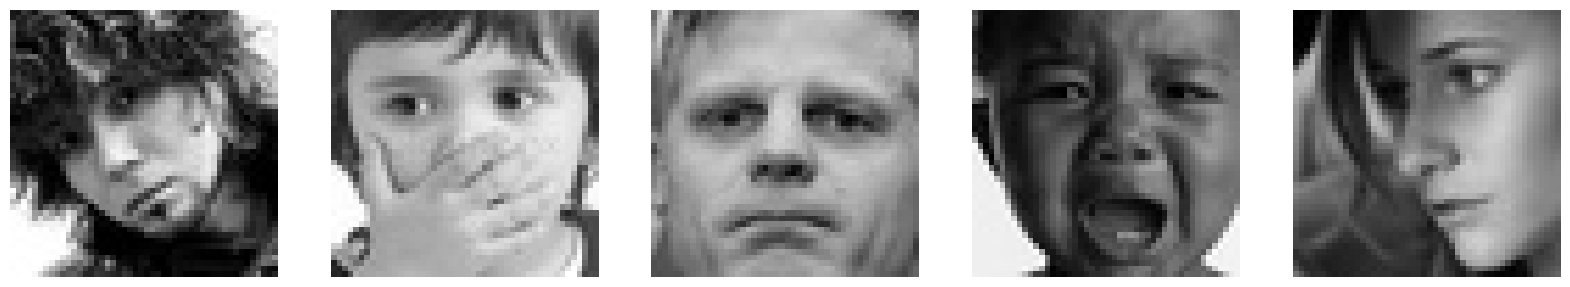

In [9]:
# Visualization of `val_path`

plot_images(val_path)

Class :  fear


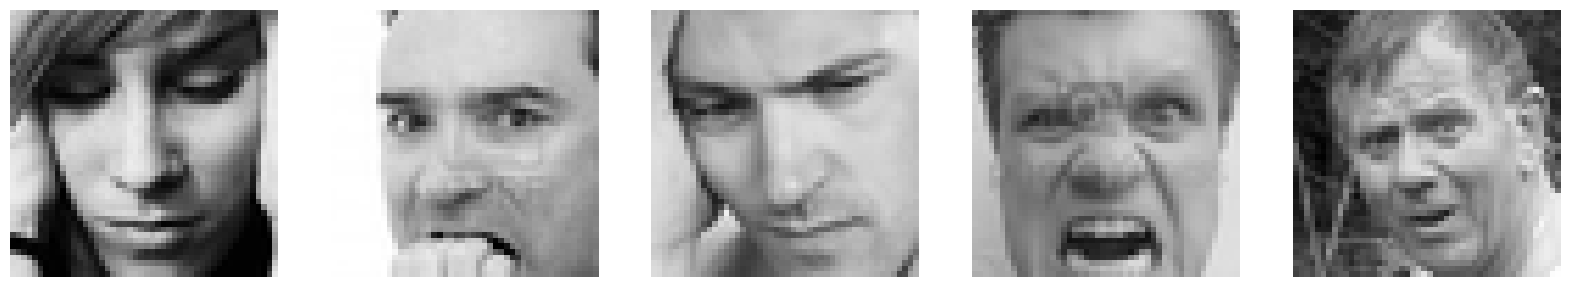

Class :  surprise


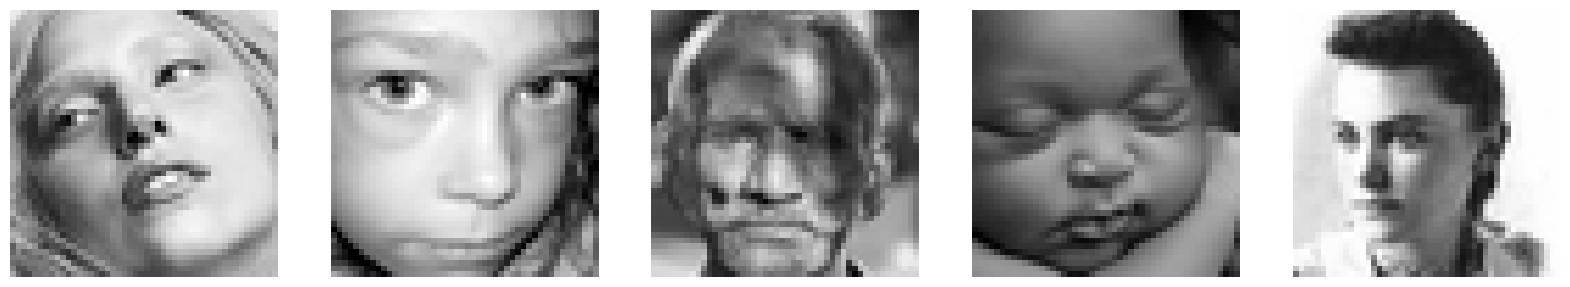

Class :  happy


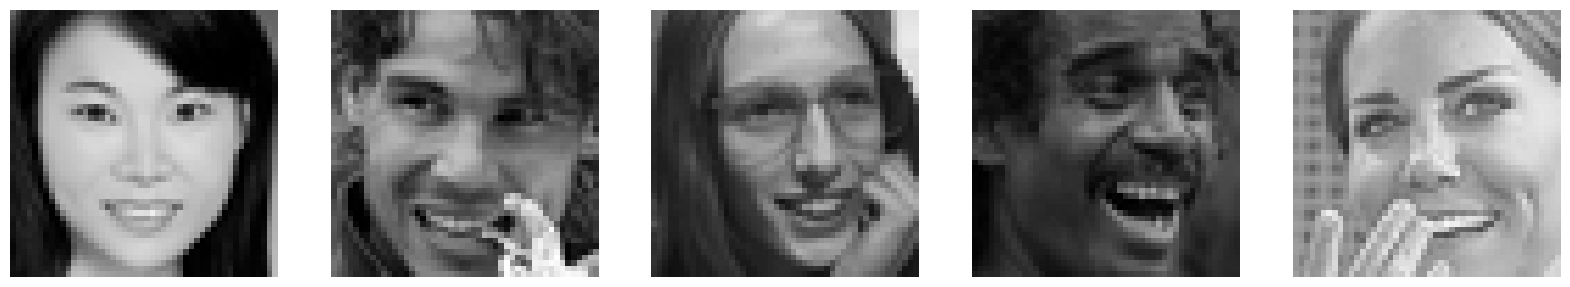

Class :  angry


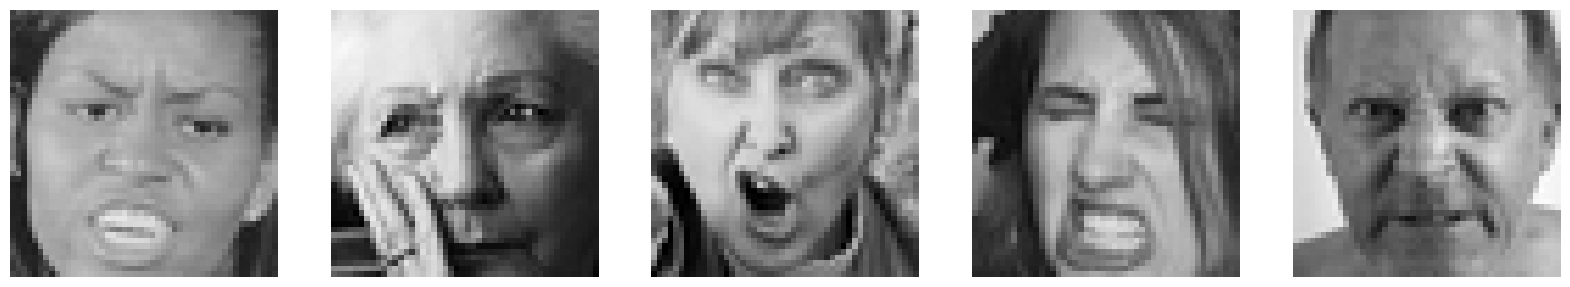

Class :  disgust


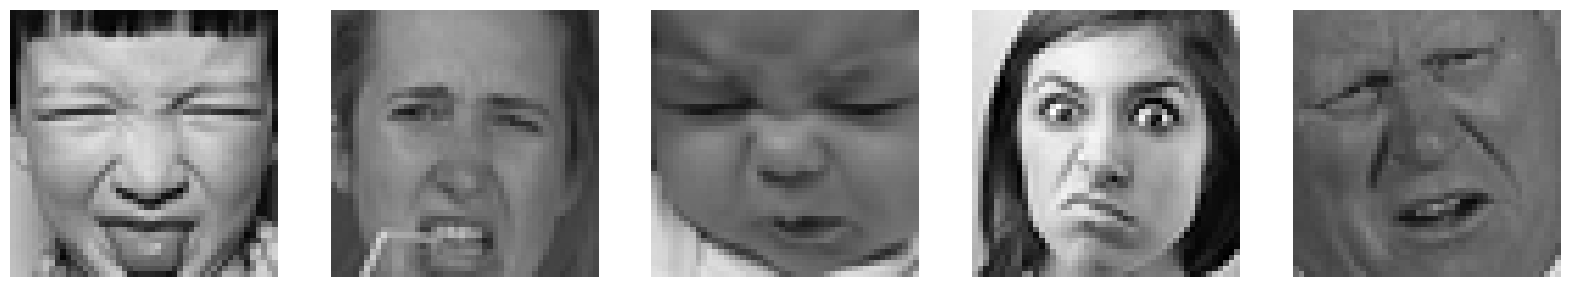

Class :  neutral


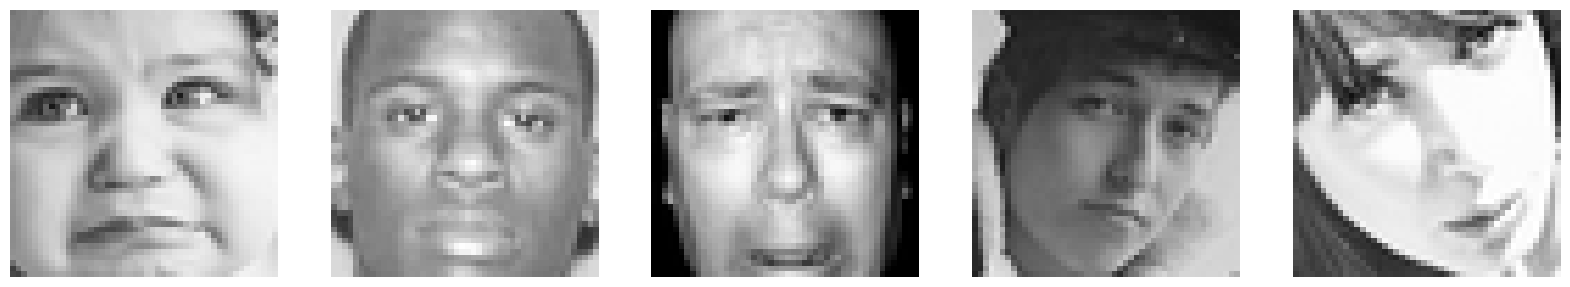

Class :  sad


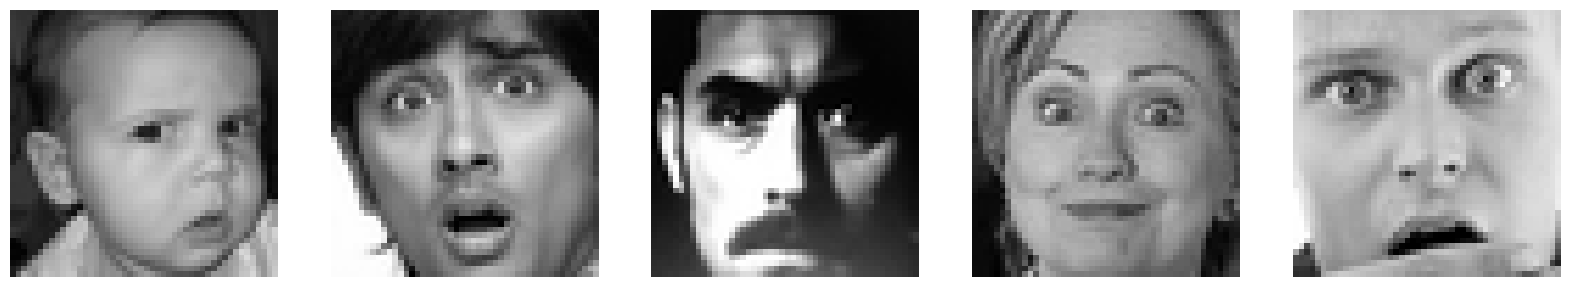

In [10]:
# Visualization of `test_path`

plot_images(test_path)

## Set Distribution

In [11]:
def plot_data_distribution(main_dir):
    subsets = ['train', 'test', 'validation']
    for subset in subsets:
        subset_path = os.path.join(main_dir, subset)
        if os.path.exists(subset_path):
            print(f'Data distribution for {subset}:')
            emotions = []
            num_files_list = []
            for emotion in os.listdir(subset_path):
                emotion_path = os.path.join(subset_path, emotion)
                if os.path.isdir(emotion_path):
                    num_files = len(os.listdir(emotion_path))
                    print(f'{emotion}: {num_files}')
                    emotions.append(emotion)
                    num_files_list.append(num_files)
            plt.figure(figsize=(10, 5))
            plt.bar(emotions, num_files_list)
            plt.title(f'Data Distribution for {subset}')
            plt.xlabel('Emotion')
            plt.ylabel('Number of Images')
            plt.show()
            print('\n')
        else:
            print(f'{subset_path} does not exist.\n')

Data distribution for train:
fear: 4103
surprise: 3205
happy: 7164
angry: 3993
disgust: 436
neutral: 4982
sad: 4938


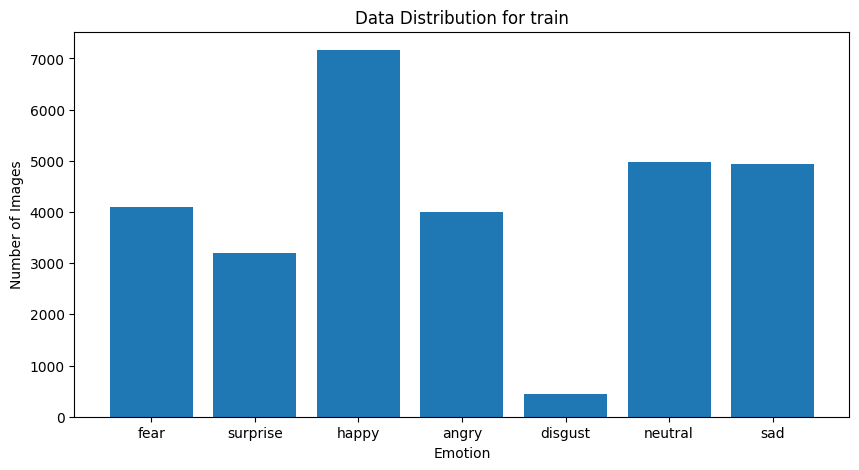



Data distribution for test:
fear: 528
surprise: 626
happy: 879
angry: 491
disgust: 55
neutral: 594
sad: 416


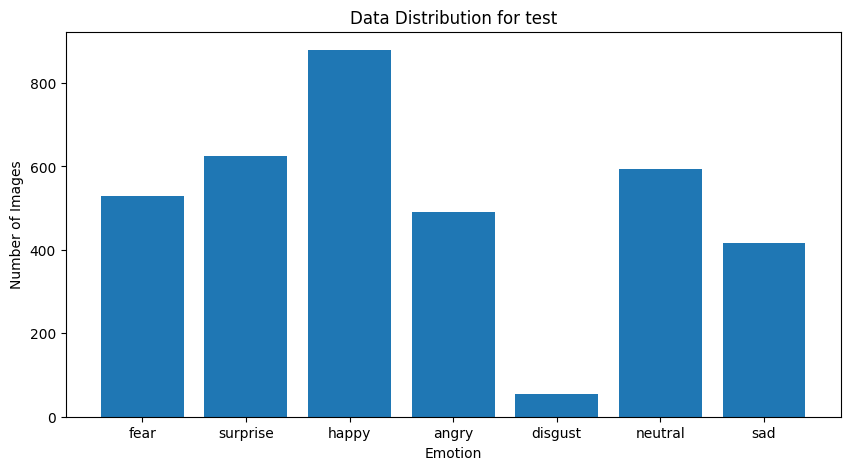



Data distribution for validation:
fear: 1018
surprise: 797
happy: 1825
angry: 960
disgust: 111
neutral: 1216
sad: 1139


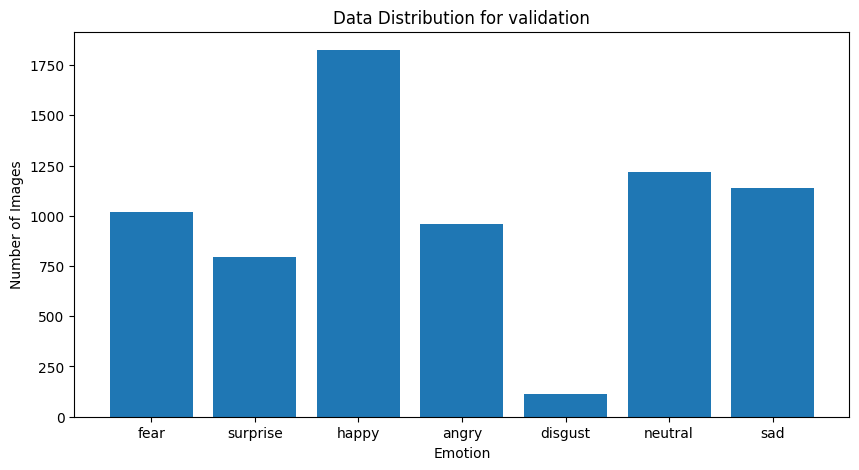

In [12]:
plot_data_distribution('/content/archive(6)/')

# v. Modeling ANN

## v.i. Preprocessing

In [ ]:
# Define hyperparameters

img_height= 48
img_width= 48
batch_size= 64

In [ ]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              color_mode='grayscale',
                                              # subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            color_mode='grayscale',
                                            # subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            color_mode='grayscale',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
# Show labels

train_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## v.ii. Model Definition

In [ ]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Sequential API model

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed), input_shape=(img_height, img_width,1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3),activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5, seed=seed))
model.add(Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed)))
model.add(Dense(7, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed)))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

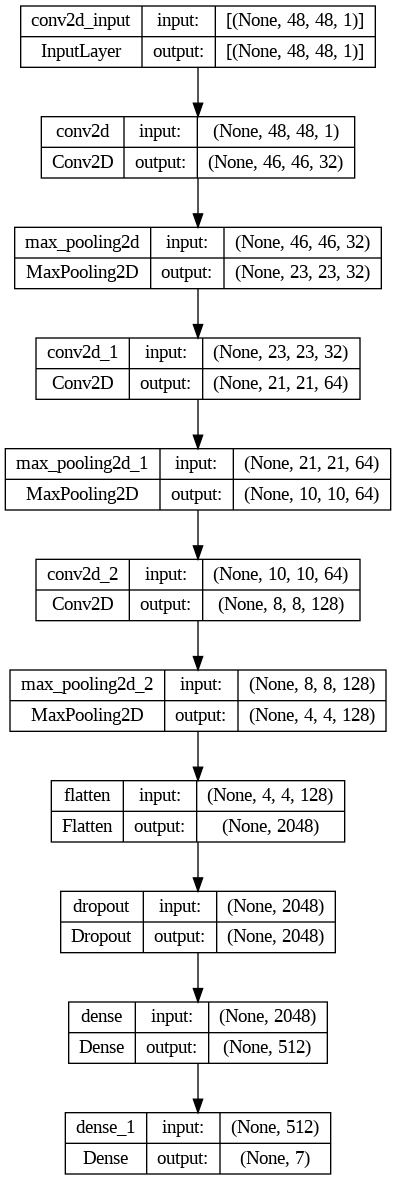

In [ ]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## v.iii. Model Training

In [ ]:
# Train the model

%%time
history = model.fit(train_set, epochs=30, validation_data=val_set, batch_size=batch_size)

Epoch 1/30
451/451 [==============================] - 14s 29ms/step - loss: 1.6829 - accuracy: 0.3235 - val_loss: 1.4823 - val_accuracy: 0.4355
Epoch 2/30
451/451 [==============================] - 12s 28ms/step - loss: 1.4458 - accuracy: 0.4407 - val_loss: 1.3403 - val_accuracy: 0.4849
Epoch 3/30
451/451 [==============================] - 12s 27ms/step - loss: 1.3356 - accuracy: 0.4887 - val_loss: 1.2683 - val_accuracy: 0.5239
Epoch 4/30
451/451 [==============================] - 12s 27ms/step - loss: 1.2716 - accuracy: 0.5137 - val_loss: 1.2147 - val_accuracy: 0.5417
Epoch 5/30
451/451 [==============================] - 12s 26ms/step - loss: 1.2130 - accuracy: 0.5403 - val_loss: 1.1743 - val_accuracy: 0.5569
Epoch 6/30
451/451 [==============================] - 12s 27ms/step - loss: 1.1704 - accuracy: 0.5567 - val_loss: 1.1537 - val_accuracy: 0.5640
Epoch 7/30
451/451 [==============================] - 12s 28ms/step - loss: 1.1343 - accuracy: 0.5737 - val_loss: 1.1544 - val_accuracy:

## v.iv. Model Evaluation

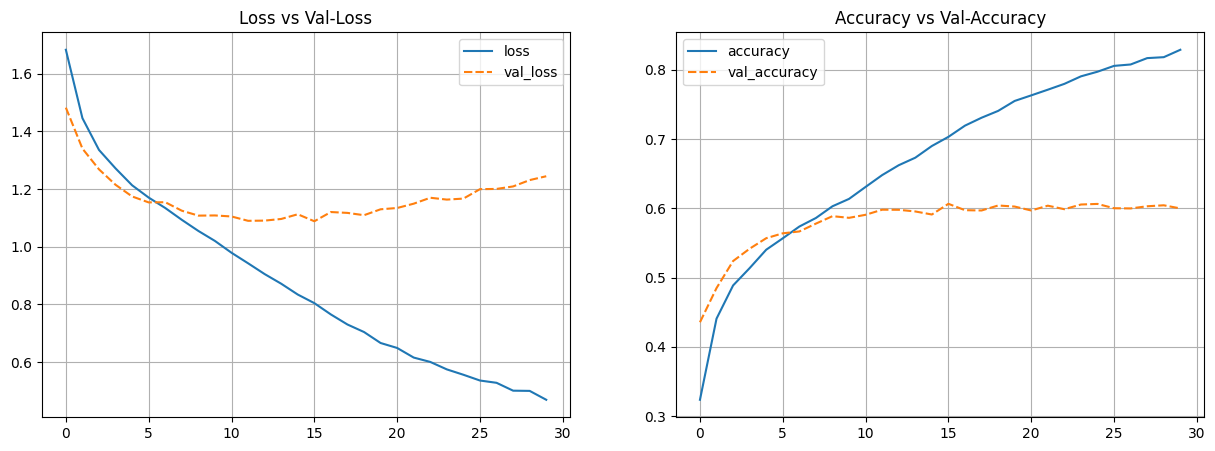

In [ ]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [ ]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict_generator(test_set)

## Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)
# y_pred_class = (y_pred_prob > 0.5).astype(int)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

              precision    recall  f1-score   support

       angry       0.88      0.88      0.88       491
     disgust       0.91      0.93      0.92        55
        fear       0.89      0.82      0.86       528
       happy       0.93      0.96      0.94       879
     neutral       0.04      0.04      0.04       594
         sad       0.01      0.01      0.01       416
    surprise       0.01      0.01      0.01       626

    accuracy                           0.50      3589
   macro avg       0.52      0.52      0.52      3589
weighted avg       0.50      0.50      0.50      3589



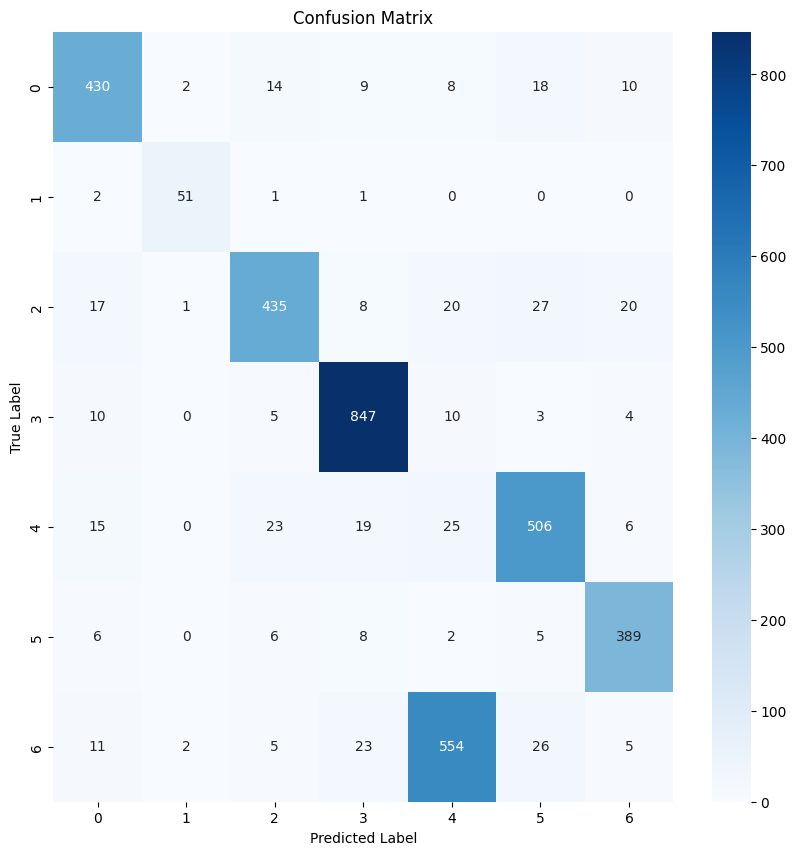

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(test_set.classes, y_pred_class)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

- Dapat dilihat dari plot bahwa penurunan validation accuracy dan loss di awal  stabil, akan tetapi setelah epoch 5 model tidak dapat mempelajari dengan baik.
- Model dapat dikatakan Overfit karena training accuracy 80%+ dan validation accuracy hanya dapat sekitar 60%+. Bisa  dilihat pada epoch ke 10 val loss sudah tidak menurun, dan kemudian meningkat.
- Hasil dari test set tidak berjauh beda dari hasil validasi yaitu sebesar 50%.
- Model kesulitan memprediksi ekspresi neutral, sad, dan surprise. Salah satu faktor yaitu sedikitnya distribusi data pada kategori tersebut.

# vi. ANN Improvement (Data Augmentation)

## vi. Preprocessing

In [ ]:
# Define hyperparameters

img_height= 48
img_width= 48
batch_size= 64

In [ ]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                    # validation_split=0.15,
                                                                    rotation_range = 10,    # randomly rotate images in the range (degrees, 0 to 180)
                                                                    zoom_range = 0.1,       # Randomly zoom image
                                                                    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                                                    height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                                                                    horizontal_flip = True, # randomly flip images
                                                                    vertical_flip=False)
val_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              color_mode='grayscale',
                                              # subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set_aug = val_datagen_aug.flow_from_directory(val_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            color_mode='grayscale',
                                            # subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            color_mode='grayscale',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


## vi.ii. Model Definition

In [ ]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create Sequential API model

model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed), input_shape=(img_height, img_width,1)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3,3), activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3,3),activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5, seed=seed))
model_aug.add(Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed)))
model_aug.add(Dense(7, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed)))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

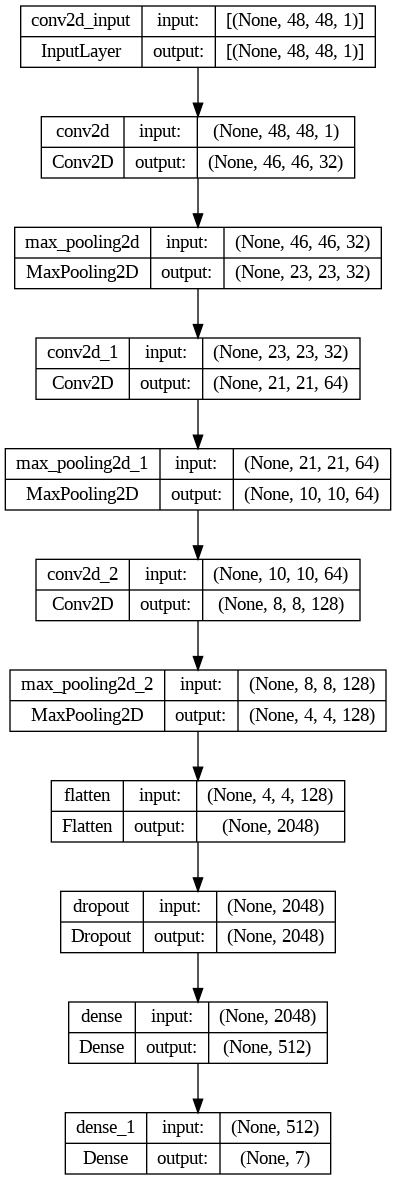

In [ ]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

## vi.iii. Model Training

In [ ]:
# Train the model

%%time
history_aug = model_aug.fit(train_set_aug, epochs=30, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/30
451/451 [==============================] - 28s 59ms/step - loss: 1.7707 - accuracy: 0.2715 - val_loss: 1.6621 - val_accuracy: 0.3530
Epoch 2/30
451/451 [==============================] - 24s 54ms/step - loss: 1.6439 - accuracy: 0.3449 - val_loss: 1.4833 - val_accuracy: 0.4329
Epoch 3/30
451/451 [==============================] - 25s 54ms/step - loss: 1.5345 - accuracy: 0.4004 - val_loss: 1.3467 - val_accuracy: 0.4840
Epoch 4/30
451/451 [==============================] - 24s 53ms/step - loss: 1.4505 - accuracy: 0.4382 - val_loss: 1.3164 - val_accuracy: 0.5017
Epoch 5/30
451/451 [==============================] - 25s 55ms/step - loss: 1.4099 - accuracy: 0.4564 - val_loss: 1.2614 - val_accuracy: 0.5167
Epoch 6/30
451/451 [==============================] - 23s 52ms/step - loss: 1.3711 - accuracy: 0.4744 - val_loss: 1.2623 - val_accuracy: 0.5221
Epoch 7/30
451/451 [==============================] - 25s 55ms/step - loss: 1.3503 - accuracy: 0.4817 - val_loss: 1.2242 - val_accuracy:

## vi.iv. Model Evaluation

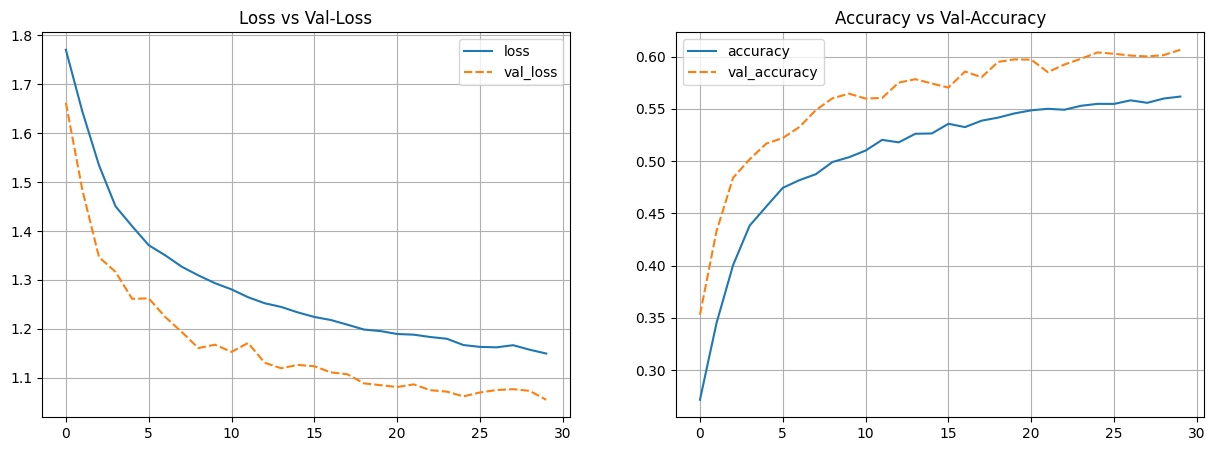

In [ ]:
# Plot training results

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [ ]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict_generator(test_set)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)
# y_pred_class_aug = (y_pred_prob > 0.5).astype(int)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

              precision    recall  f1-score   support

       angry       0.53      0.62      0.57       491
     disgust       0.57      0.15      0.23        55
        fear       0.56      0.30      0.39       528
       happy       0.78      0.89      0.83       879
     neutral       0.17      0.22      0.19       594
         sad       0.01      0.01      0.01       416
    surprise       0.04      0.03      0.03       626

    accuracy                           0.39      3589
   macro avg       0.38      0.32      0.32      3589
weighted avg       0.39      0.39      0.38      3589



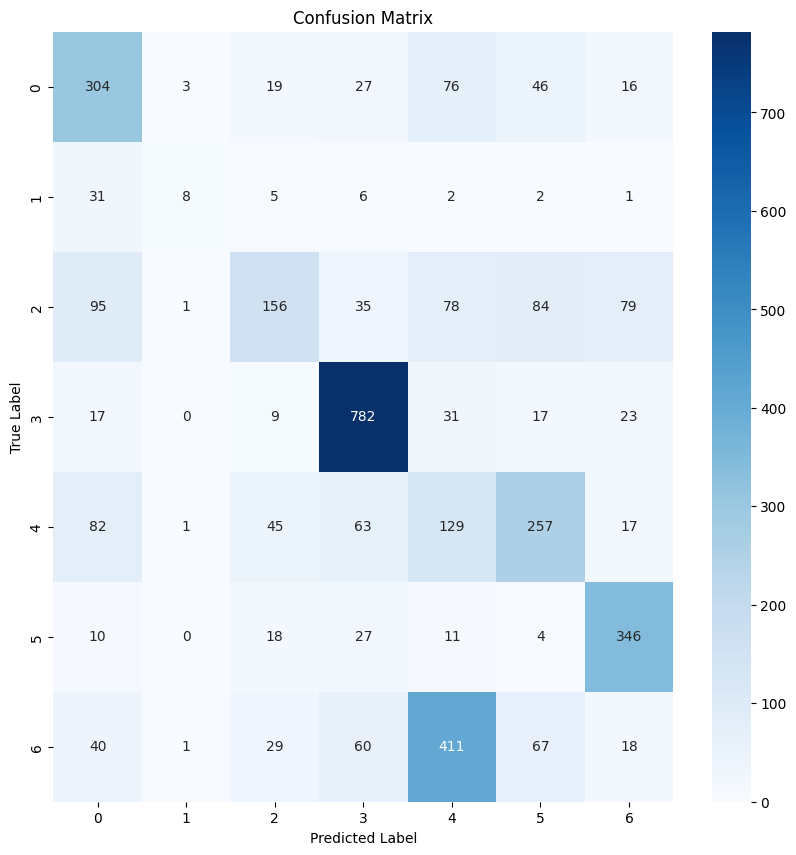

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(test_set.classes, y_pred_class_aug)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

- Dapat dilihat dari plot bahwa penurunan validation accuracy dan loss di awal stabil, akan tetapi setelah kenaikan masih berlanjut, sehingga dibutuhkan untuk menambah epoch.
- Model dapat dikatakan Goodfit karena training accuracy dan validation accuracy tidak berbeda jauh.
- Hasil dari test set lebih buruk daripada model yang sebelumnya dikarnakan model belum mencapai titik optimal.
- Model kesulitan memprediksi ekspresi neutral, sad, dan surprise. Salah satu faktor yaitu sedikitnya distribusi data pada kategori tersebut.

# vii. ANN Improvement 2  (Without Data Augmentation)

## vi. Preprocessing

In [28]:
# Define hyperparameters

img_height= 48
img_width= 48
batch_size= 64

In [29]:
# Create batch generator for train-set, val-set, and test-set

train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                    # validation_split=0.15,
                                                                    # rotation_range = 10,    # randomly rotate images in the range (degrees, 0 to 180)
                                                                    # zoom_range = 0.2,       # Randomly zoom image
                                                                    # width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                                                    # height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
                                                                    # horizontal_flip = True, # randomly flip images
                                                                    # vertical_flip=False
                                                                    )
val_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              color_mode='grayscale',
                                              # subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set_aug = val_datagen_aug.flow_from_directory(val_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            color_mode='grayscale',
                                            # subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            color_mode='grayscale',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


## vi.ii. Model Definition

In [40]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

num_features = 64
num_labels = 7
width, height = 48, 48

In [41]:
model_aug = Sequential()

model_aug.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model_aug.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_aug.add(Dropout(0.5))

model_aug.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_aug.add(BatchNormalization())
model_aug.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_aug.add(Dropout(0.5))

model_aug.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_aug.add(BatchNormalization())
model_aug.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_aug.add(Dropout(0.5))

model_aug.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_aug.add(BatchNormalization())
model_aug.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model_aug.add(BatchNormalization())
model_aug.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_aug.add(Dropout(0.5))

model_aug.add(Flatten())

model_aug.add(Dense(2*2*2*num_features, activation='relu'))
model_aug.add(Dropout(0.4))
model_aug.add(Dense(2*2*num_features, activation='relu'))
model_aug.add(Dropout(0.4))
model_aug.add(Dense(2*num_features, activation='relu'))
model_aug.add(Dropout(0.5))

model_aug.add(Dense(num_labels, activation='softmax'))

# Compile
model_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       7

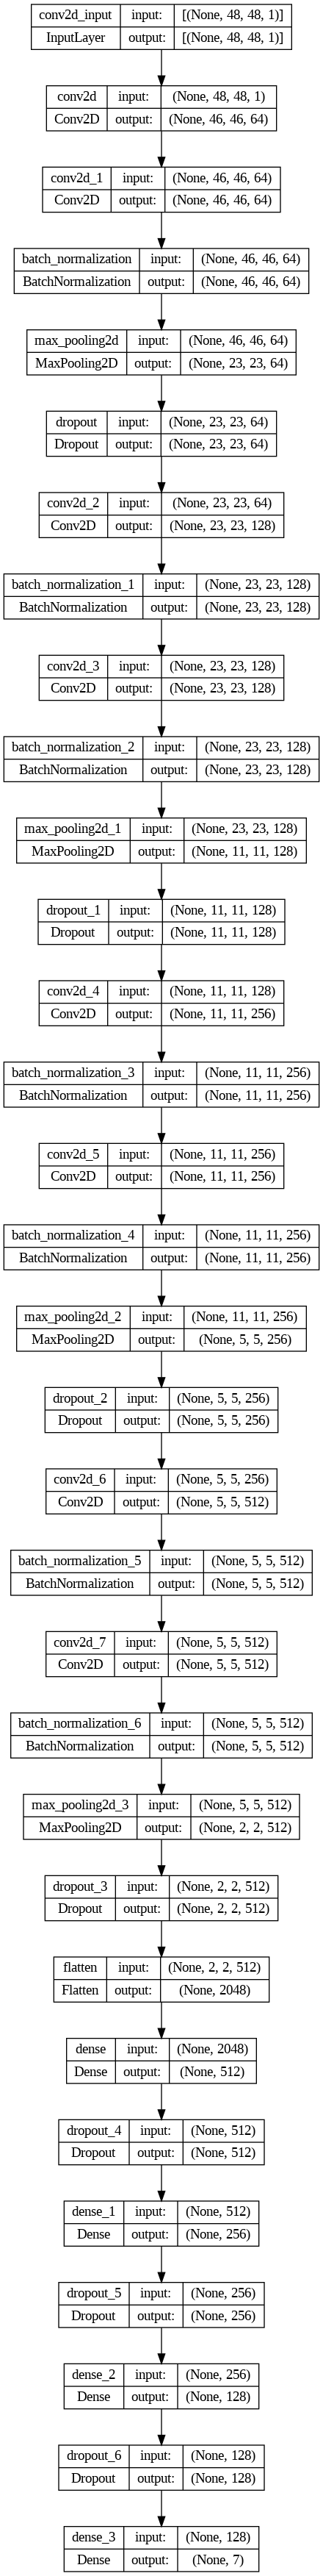

In [42]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

## vi.iii. Model Training

In [43]:
model_es = EarlyStopping(monitor = 'val_loss', mode = 'auto', patience = 8)#, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.9, patience = 3)#, mode = 'min')

1. `EarlyStopping`: Fungsi ini akan menghentikan pelatihan ketika metrik yang dipantau tidak lagi meningkat.
    - `monitor='val_loss'`: Ini berarti `val_loss` model dipantau selama pelatihan.
    - `mode='min'`: Pelatihan akan berhenti ketika kuantitas yang dipantau (dalam hal ini `val_loss`) berhenti menurun.
    - `patience=5`: Jumlah epoch tanpa peningkatan setelah itu pelatihan akan dihentikan. Jadi, pelatihan berhenti jika `val_loss` tidak menurun selama 5 epoch.

2. `ReduceLROnPlateau`: Fungsi ini mengurangi learning rate ketika metrik telah berhenti meningkat.
    - `monitor='val_loss'`: Ini berarti `val_loss` model dipantau selama pelatihan.
    - `factor=0.9`: Faktor dimana learning rate akan dikurangi. `new_lr = lr * factor`.
    - `patience=3`: Jumlah epoch tanpa peningkatan setelah itu learning rate akan dikurangi. Jadi, learning rate dikurangi jika `val_loss` tidak menurun selama 3 epoch.
    - `mode='min'`: Learning rate akan dikurangi ketika kuantitas yang dipantau (`val_loss` dalam hal ini) telah berhenti menurun.

In [44]:
# Train the model

%%time
history_aug = model_aug.fit(train_set_aug, epochs=100, validation_data=val_set_aug, batch_size=batch_size, callbacks = [model_rlr])

Epoch 1/100
451/451 [==============================] - 33s 62ms/step - loss: 1.9857 - accuracy: 0.2107 - val_loss: 1.8200 - val_accuracy: 0.2583 - lr: 0.0010
Epoch 2/100
451/451 [==============================] - 30s 67ms/step - loss: 1.8340 - accuracy: 0.2412 - val_loss: 1.8538 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 3/100
451/451 [==============================] - 27s 60ms/step - loss: 1.8116 - accuracy: 0.2524 - val_loss: 1.8027 - val_accuracy: 0.2586 - lr: 0.0010
Epoch 4/100
451/451 [==============================] - 27s 61ms/step - loss: 1.7321 - accuracy: 0.2970 - val_loss: 1.6628 - val_accuracy: 0.3255 - lr: 0.0010
Epoch 5/100
451/451 [==============================] - 27s 60ms/step - loss: 1.5987 - accuracy: 0.3659 - val_loss: 1.5879 - val_accuracy: 0.3815 - lr: 0.0010
Epoch 6/100
451/451 [==============================] - 27s 60ms/step - loss: 1.5031 - accuracy: 0.4086 - val_loss: 1.4183 - val_accuracy: 0.4452 - lr: 0.0010
Epoch 7/100
451/451 [==============================]

## vi.iv. Model Evaluation

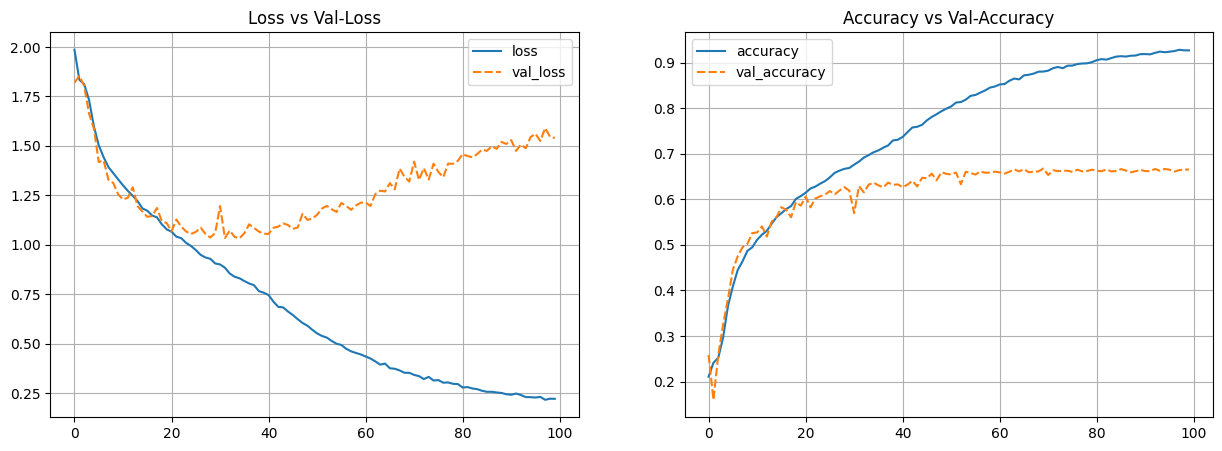

In [45]:
# Plot training results

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [46]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict_generator(test_set_aug)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)
# y_pred_class_aug = (y_pred_prob > 0.5).astype(int)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

              precision    recall  f1-score   support

       angry       0.91      0.92      0.91       491
     disgust       0.92      0.89      0.91        55
        fear       0.90      0.89      0.89       528
       happy       0.97      0.97      0.97       879
     neutral       0.05      0.06      0.05       594
         sad       0.00      0.00      0.00       416
    surprise       0.00      0.00      0.00       626

    accuracy                           0.52      3589
   macro avg       0.54      0.53      0.53      3589
weighted avg       0.52      0.52      0.52      3589



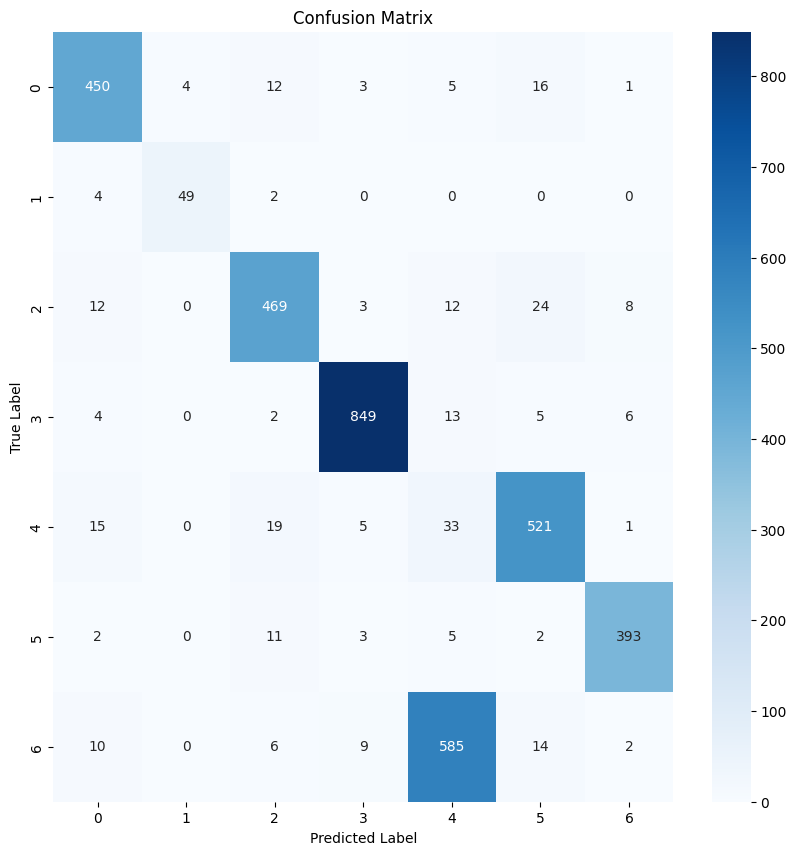

In [47]:
# Generate the confusion matrix
cm = confusion_matrix(test_set_aug.classes, y_pred_class_aug)

# Display the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

- Dapat dilihat dari plot bahwa penurunan validation accuracy dan loss di awal stabil, akan tetapi setelah kenaikan masih berlanjut, Hingga sekitar Epoch 50 tidak meningkat lagi
- Performa Model ini mirip dengan model awal dapat dikatakan Overfit karena training accuracy meningkat dan validation accuracy tidak meningkat seiring berjalannya epoch.
- Hasil dari test set lebih baik / ada peningkatan daripada model yang sebelumnya setelah di train untuk 100 epoch menjadi 52%
- Model kesulitan memprediksi ekspresi neutral, sad, dan surprise. Salah satu faktor yaitu sedikitnya distribusi data pada kategori tersebut.

# vii. Model Saving

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Model Saving
model.save('/content/drive/MyDrive/Hacktiv8/P2G7/my_model.keras')

In [49]:
model_aug.save('/content/drive/MyDrive/Hacktiv8/P2G7/model_best.keras')

# viii. Model Inference

Model inference pada notebook `P2G7_raymond-samuel_inference.ipynb`

# ix. Pengambilan Kesimpulan

- Pembuatan model sudah tercapai sesuai dengan objective yaitu Membuat Model ANN untuk prediksi Emosi Wajah yang akan digunakan untuk mengetahui Ekpresi peserta kelas Hacktiv8 untuk meningkatkan efektifitas pembelajaran.
- Model masih belum mendapatkan hasil yang baik, bisa dilihat dari test-set tertinggi masih terletak pada model yang menggunakan ANN biasa dengan data normal yaitu sebesar 50%, sedangkan menggunakan data augmentasi lebih rendah dan sebaiknya dilakukan training lanjutan.
- Untuk model pada ANN improvement 2, di train sebesar 100 epoch dan hasil dapat dilihat mendapatkan test set sebesar 52%, meningkat sedikit dibanding yang model lain nya.
- Rendah nya akurasi bisa dikatakan karena distribusi data yang tidak merata dan ada beberapa kelas yang memiliki data lebih sedikit dibanding kelas yang lain.
- Arsitektur masih dapat diimprove dengan eksperimen lebih lanjut.